# The Third LDA Model: Business Markets with 811 articles

## #1. General information

This is a script that helps you explore the third LDA model. It is a part of a Book Chapter "***How can a machine learning-based LDA model help identify relevant literature?***" by A. Akagić & S. Kadić-Maglajlić, published in a book *Handbook of Engaged Marketing Research: How to design for purposeful and impactful research*.

Please follow instructions below.

Please email the creators of these scripts if you are unable to run them, or have some questions: aakagic@etf.unsa.ba, skm.marktg@cbs.dk. 

## #2. Install required packages


In [1]:
!pip install scikit-learn==0.24.1
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
!pip install pyLDAvis
!pip install gensim

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz (538.1 MB)
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.4.0-py3-none-any.whl size=538899688 sha256=d1bc76f6c9699e4f743468abdc5eb9d0711ecf90e94d4c67af1e8b9c62d5eb34
  Stored in directory: c:\users\addy\appdata\local\pip\cache\wheels\87\6f\e6\a51909709009e9a36e5385cff94257a7fc036ff2f9670e71f8
Successfully built en-core-sci-lg


In [2]:
!pip install pandas --upgrade

Requirement already up-to-date: pandas in c:\users\addy\anaconda3\lib\site-packages (1.3.5)


## #3. Load packages

In [1]:
import numpy as np 
import pandas as pd
import sys
import os

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_lg

import gensim

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## #4. Load articles (body text)

In [2]:
print('Loading and Preprocessing Data')
filename = 'data/Business_Markets_selected_papers_per_topic_5.csv'
df = pd.read_csv(filename)
is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

Loading and Preprocessing Data


## #5. Load other important files and functions that will be used later.

In [3]:
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 6010000

Load different functions which will be used later. 

In [4]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2021, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        temp = doc_topic_dist[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist[relevant_time]
    
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest
    
def get_k_nearest_docs2(doc_dist, k=5, lower=1950, upper=2021, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    doc_topic_dist2 = doc_topic_dist.iloc[:, 0:20]
        
    if only_covid19:
        temp = doc_topic_dist2[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist2[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

def plot_article_dna(paper_id, width=20):
    t = df[df.paper_id == paper_id].title.values[0]
    doc_topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    t = df[df.paper_id == recommendation_id].title.values[0]
    temp = doc_topic_dist[df.paper_id == paper_id]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

# compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(paper_id, recommendation_ids[i])
            plt.show(ax)

def recommendation(paper_id, k=5, lower=1950, upper=2021, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    print(df.title[df.paper_id == paper_id].values[0])

    recommended, dist = get_k_nearest_docs(doc_topic_dist[df.paper_id == paper_id].iloc[0], k, lower, upper, only_covid19, get_dist=True)
    recommended = df.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
    display(HTML(h))
    
    if plot_dna:
        compare_tabs(paper_id, recommended.paper_id.values)

def info_about_paper(paper_id):
    '''
    Returns the most important data about the paper.
    '''
    
    h = '<br/> <strong>Title</strong>: <a href="' + str(df.url[df.paper_id == paper_id].values[0]) + '" target="_blank">' + str(df.title[df.paper_id == paper_id].values[0]) + '</a> <br/> <strong>Authors</strong>: ' + str(df.authors[df.paper_id == paper_id].values[0]) + '<br/> <strong>Journal</strong>: ' + str(df.journal[df.paper_id == paper_id].values[0]) + '<br/> <strong>Publish time</strong>: ' + str(df.publish_time[df.paper_id == paper_id].values[0]) + '<br/> <strong>Abstract</strong>: ' + str(df.abstract[df.paper_id == paper_id].values[0]) + '<br/> <strong>Body text</strong>: ' + str(df.body_text[df.paper_id == paper_id].values[0]) + ''
    display(HTML(h))

def related_papers():
    '''
    Creates a widget where you can select one of many papers about covid-19 and then displays related articles from the whole dataset.
    '''
    covid_papers = df[df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')][['paper_id', 'title']] # are there more names?
    title_to_id = covid_papers.set_index('title')['paper_id'].to_dict()
    
    def main_function(bullet, k=5, year_range=[1950, 2021], only_covid19=False):
        recommendation(title_to_id[bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
    
    yearW = widgets.IntRangeSlider(min=1950, max=2021, value=[2010, 2021], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=False,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='20%'))

    bulletW = widgets.Select(options=title_to_id.keys(), layout=Layout(width='90%', height='200px'), description='Title:')

    widget = widgets.interactive(main_function, bullet=bulletW, k=kWidget, year_range=yearW, only_covid19=covidW)

    controls = VBox([Box(children=[widget.children[:-1][1], widget.children[:-1][2], widget.children[:-1][3]], 
                         layout=Layout(justify_content='space-around')), widget.children[:-1][0]])
    output = widget.children[-1]
    display(VBox([controls, output]))

def relevant_articles(tasks, k=3, lower=1950, upper=2021, only_covid19=False):
    tasks = [tasks]
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))
    
    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended, dist = get_k_nearest_docs2(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19, get_dist=True)
        recommended = df.iloc[recommended].copy()
        recommended['similarity'] = 1 - dist 

        #h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
        #display(HTML(h))
        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
        display(HTML(h))

def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2021, value=[2010, 2021], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

In [5]:
vectorizer = joblib.load('model_business_markets/vectorizer.csv')
lda = joblib.load('model_business_markets/lda.csv')
data_vectorized = joblib.load('model_business_markets/data_vectorized.csv')
doc_topic_dist = pd.read_csv('model_business_markets/doc_topic_dist.csv')

## #6. Explore the text corpus from CSV file.

### #6.1 How many papers are in the text corpus?

In [6]:
# Number of papers
print("The number of papers in the csv file is: " + str(len(df)))

The number of papers in the csv file is: 712


### #6.2 Get the paper ID of the row #:

In [7]:
df.iloc[100].paper_id

'7227cfed1d27da7d4fc5ba419519399ccc1a3960'

In [8]:
df.iloc[100]

paper_id                     7227cfed1d27da7d4fc5ba419519399ccc1a3960
body_text           Return of products by customers is a common ph...
methods             To examine the impact of online reviews, we co...
results                                                           NaN
source                                         Elsevier; Medline; PMC
title               The impact of online reviews in the presence o...
doi                                        10.1016/j.ijpe.2020.107929
abstract            We develop a duopoly model to examine how onli...
publish_time                                               2020-09-19
authors                   Sun, Miao; Chen, Jing; Tian, Ye; Yan, Yufei
journal                                               Int J Prod Econ
mag_id                                                            NaN
who_covidence_id                                                  NaN
arxiv_id                                                          NaN
pdf_json_files      

### #6.3 Print all information about a paper:

In [10]:
info_about_paper('7227cfed1d27da7d4fc5ba419519399ccc1a3960')

Same as previous, but here we use row ID:

In [11]:
info_about_paper(df.iloc[711].paper_id)

### #6.4 Information about the dataframe structure. Here you can see number of columns and their description, as well as the number of Non-null rows.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paper_id          712 non-null    object 
 1   body_text         712 non-null    object 
 2   methods           402 non-null    object 
 3   results           285 non-null    object 
 4   source            689 non-null    object 
 5   title             689 non-null    object 
 6   doi               670 non-null    object 
 7   abstract          663 non-null    object 
 8   publish_time      689 non-null    object 
 9   authors           689 non-null    object 
 10  journal           588 non-null    object 
 11  mag_id            0 non-null      float64
 12  who_covidence_id  0 non-null      float64
 13  arxiv_id          21 non-null     float64
 14  pdf_json_files    689 non-null    object 
 15  pmc_json_files    571 non-null    object 
 16  url               689 non-null    object 
 1

This is a list of paper IDs.

In [13]:
all_paper_ids = df.paper_id

This is a list of papers between 100 and 200.

In [14]:
all_paper_ids.iloc[100:200]

100    7227cfed1d27da7d4fc5ba419519399ccc1a3960
101    bbaa03b2f41f809c2fdbf56410c9280fd73436be
102    7271610d2704021f785b4a7b6ab40a48fc5a2691
103    ebb5fe3a06a8abaa3ef8d657f24f6c5da3969622
104    fc15db78a273454de68b916ca83449edfedc5c93
                         ...                   
195    58b2a8d86bf8bc2bb101c30202acebaeaf95f26d
196    06d36734d0040b8a67594f02dc71ee2908b0ed93
197    fc6a5218798478314f08f7c5dff8583a2107a08c
198    9ec37a85e75cb64d1c35de280a3f5822ce88ebf4
199    589fa7b6680f8612d93ecce5c16d24220bdc9024
Name: paper_id, Length: 100, dtype: object

### #6.5 Example of first 10 rows in the dataframe.

In [15]:
df.head()

,paper_id,body_text,methods,results,source,title,doi,abstract,publish_time,authors,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,publish_year,is_covid19,study_design
0,acfb6e59bf5f762b7a749c4bdc3613360fdc2160,In the midst of a global COVID-19 pandemic (Wo...,The purpose of this conceptual mixed-methods s...,The first stage of the research analyzed the s...,Elsevier; Medline; PMC,Independent restaurant operator perspectives i...,10.1016/j.ijhm.2020.102766,The purpose of this study was to assess the pe...,2020-11-19,"Brizek, Michael G.; Frash, Robert E.; McLeod, ...",...,NaN,NaN,NaN,document_parses/pdf_json/acfb6e59bf5f762b7a749...,document_parses/pmc_json/PMC7674148.xml.json,https://www.sciencedirect.com/science/article/...,227033580.0,2020,True,"['protocol', 'association']"
1,701fba6a3db6f1b2dcb991ae9e5f35033a042eed,The consensus around the origin and the forms ...,"For the purpose of this study, primary data is...",Males are more likely to use digital modes of ...,PMC,Digital payments and consumer experience in In...,10.1007/s42786-020-00024-z,Propelled by recent policy initiatives and tec...,2021-01-05,"Shree, Sudiksha; Pratap, Bhanu; Saroy, Rajas; ...",...,NaN,NaN,NaN,document_parses/pdf_json/701fba6a3db6f1b2dcb99...,document_parses/pmc_json/PMC7784624.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2021,True,"['baseline', 'logistic regression', 'estimatio..."
2,d36cf39ab9c6371dbedb42afe11cd6817046e45d,A crisis is both a threat and an opportunity t...,NaN,NaN,Elsevier; WHO,Which crisis strategies are (expectedly) effec...,10.1016/j.jbvi.2021.e00273,We investigate COVID-19 as a disabling and an ...,2021-11-30,"Klyver, Kim; Nielsen, Suna Løwe",...,NaN,NaN,NaN,document_parses/pdf_json/d36cf39ab9c6371dbedb4...,NaN,https://api.elsevier.com/content/article/pii/S...,237549160.0,2021,True,['association']
3,73644ec24152dda17b8dcb273a0fd8a8235519fe,Purpose-driven companies are those that have r...,The overall objective of this research is to u...,Group 1 was exposed to stimuli without corpora...,Medline; PMC,The Corporate Purpose of Spanish Listed Compan...,10.3389/fpsyg.2020.02108,Purpose driven companies have developed their ...,2020-10-06,"Mañas-Viniegra, Luis; González-Villa, Igor-Ale...",...,NaN,NaN,NaN,document_parses/pdf_json/73644ec24152dda17b8dc...,document_parses/pmc_json/PMC7574645.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33117206/;...,222141587.0,2020,True,['power']
4,4a01685253c3e40bb2b9f676acb3b89b2d89e9ee,Organizations rely on innovative behaviors to ...,This study examines teachers from 19 private e...,The characteristics of the teachers who partic...,Medline; PMC,The effects of knowledge sharing and person–or...,10.1016/j.heliyon.2021.e07334,Previous studies reveal a gap in the literatur...,2021-06-17,"Sudibjo, Niko; Prameswari, Ranggi Kanya",...,NaN,NaN,NaN,document_parses/pdf_json/4a01685253c3e40bb2b9f...,document_parses/pmc_json/PMC8239725.xml.json,https://doi.org/10.1016/j.heliyon.2021.e07334;...,235684531.0,2021,True,['association']


Some titles are missing, but we can still access the article through the link!

## #7. Graphical representation of an LDA model

You can change λ in the top right corner if you would like to tweak words distributions in a topic. Values of λ that are very close to 0 will show terms that are more specific for a chosen topic. Meaning that terms that are important for that specific topic will be displayed, but they may not be necessarily important for the whole corpus.

Values of λ that are very close to 1 will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus. 

For example, change λ to 0.5 to show terms that are more specific for a topic, a not for the whole corpus.

In [16]:
import IPython
IPython.display.HTML(filename='model_business_markets/lda.html')

## #8. Print selected number of words for each topic. 

Change "n_top_words" to select number of words.

In [17]:
print_top_words(lda, vectorizer, n_top_words=20)


Topic #0: corporate companies company governance board management performance financial value csr philanthropy directors investment impact accounting firm firms reporting shareholders ceo

Topic #1: brand social investors media green bank women founders banking customers female startup information waste interest banks brands email support experiment

Topic #2: smes covid-19 pandemic business financial information economic consumers e-commerce crisis government consumer sme social online businesses impact food restaurant restaurants

Topic #3: perceived model intention information consumers positive services technology mobile users customers trust significant factors value service influence relationship satisfaction variables

Topic #4: financial financing mses variables companies covid-19 species support significant model pandemic variable factors m-payment regression delivery firms donation banks customers

Topic #5: csr level cpp sq implementation dsiw manufacturing farooq industry 

## #9. Identify a dominant topic in each paper

### #9.1 Determine a dominant topic for each paper.

In [18]:
# Get dominant topic for each document
dominant_topic = np.argmax(doc_topic_dist.values, axis=1)
doc_topic_dist['dominant_topic'] = dominant_topic

### #9.2 Select only papers that belong to a specific topic ID. 

**Please note that under `topic_id` you have to specify number which is reduced by 1 from topic id presented in the visualization.**

In [19]:
topic_id = 19
test = doc_topic_dist.apply(lambda x : True
            if x['dominant_topic'] == topic_id else False, axis = 1)
new_dataframe = df.loc[doc_topic_dist[test == True].index]

### #9.3 How many papers belong to this topic?

In [20]:
len(new_dataframe)

39

### #9.4 List the first five papers that belong to this topic.

If you want more topics than modify the command in this way:

`new_dataframe.head(10)`

where 10 represents the number of papers you want to display.


In [21]:
new_dataframe.head(20)

,paper_id,body_text,methods,results,source,title,doi,abstract,publish_time,authors,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,publish_year,is_covid19,study_design
8,acbcc69ccfe10b4be2c0b0a7b5eb36c22c9b4789,Extreme events such as infectious diseases are...,The first case of COVID‐19 in Wuhan was report...,The total consumption in the two periods (from...,Medline; PMC,The variations in individual consumption chang...,10.1111/grow.12477,"Over the last two decades, scholars have point...",2021-02-02,"Xu, Jie; Gao, Ming; Zhang, Yina",...,NaN,NaN,NaN,document_parses/pdf_json/acbcc69ccfe10b4be2c0b...,document_parses/pmc_json/PMC8013447.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33821025/;...,232480304.0,2021,True,"['incidence', 'p-value', 'frequency', 'β', 'ti..."
18,12bc84ae6ee8b5e4a9645d8db87924e5e1d25167,The purpose of this research paper is to exami...,NaN,NaN,Elsevier; Medline; PMC,Impact of Covid-19 on Consumer Behavior: Will ...,10.1016/j.jbusres.2020.05.059,The COVID-19 pandemic and the lockdown and soc...,2020-06-04,"Sheth, Jagdish",...,NaN,NaN,NaN,document_parses/pdf_json/12bc84ae6ee8b5e4a9645...,document_parses/pmc_json/PMC7269931.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32536735/;...,219300570.0,2020,True,[]
23,08c2ab2c2fd27bdfbd366aa593830e8fe386a675,The restaurant business is among the industrie...,NaN,Our model-free analysis reveals significant in...,ArXiv,COVID-19 and Digital Resilience: Evidence from...,NaN,We analyze how digital platforms can increase ...,2020-06-12,"Raj, Manav; Sundararajan, Arun; You, Calum",...,NaN,NaN,2006.07204,document_parses/pdf_json/08c2ab2c2fd27bdfbd366...,NaN,https://arxiv.org/pdf/2006.07204v1.pdf,219636191.0,2020,True,[]
29,49e968729722fec9d4af46cfc2413c1003feb903,Online food retail is an increasingly popular ...,A scoping review was undertaken between April ...,Insights from the literature review informed t...,Medline; PMC,Supermarkets in Cyberspace: A Conceptual Frame...,10.3390/ijerph17228639,The rapid increase in online shopping and the ...,2020-11-20,"Khandpur, Neha; Zatz, Laura Y.; Bleich, Sara N...",...,NaN,NaN,NaN,document_parses/pdf_json/49e968729722fec9d4af4...,document_parses/pmc_json/PMC7699869.xml.json,https://doi.org/10.3390/ijerph17228639; https:...,227166577.0,2020,True,"['frequency', 'surveillance', 'association']"
30,4899b333d28f7b65b8fe78ae4b370e44e37d6ef9,The global pandemic of COVID-19 (a disease cau...,NaN,NaN,Medline; PMC; WHO,What Does Food Retail Research Tell Us About t...,10.3389/fpsyg.2020.01448,NaN,2020-06-05,"Martin-Neuninger, Rosemarie; Ruby, Matthew B.",...,NaN,NaN,NaN,document_parses/pdf_json/4899b333d28f7b65b8fe7...,document_parses/pmc_json/PMC7292029.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32581987/;...,219327239.0,2020,True,[]
69,b290211fee45c04ad36211153a9d0e6d02787910,Advertising spending in online media is on the...,"Given our research objectives, our modelling a...",We first consider the results of the brand-sal...,Elsevier; PMC,Online Display Advertising for CPG Brands: (Wh...,10.1016/j.ijresmar.2020.08.004,Abstract This study examines how online displa...,2020-08-18,"van Ewijk, Bernadette J.; Stubbe, Astrid; Gijs...",...,NaN,NaN,NaN,document_parses/pdf_json/b290211fee45c04ad3621...,NaN,https://www.sciencedirect.com/science/article/...,221157773.0,2020,False,['estimation']
73,f9dd5b3000320facbfd7c4829ca7fe4d7d2bfbf3,Childhood obesity has become a global issue in...,The Impact Assessment’s Online Baseline Method...,To estimate the annual unhealthy digital ads t...,Medline; PMC,The Devil Is in the Detail: Challenging the UK...,10.3390/ijerph17197231,Background: How much unhealthy marketing do ch...,2020-10-02,"Tatlow-Golden, Mimi; Parker, Daniel",...,NaN,NaN,NaN,document_parses/pdf_json/f9dd5b3000320facbfd7c...,document_parses/pmc_json/PMC7578928.xml.json,https://doi.org/10.3390/ijerph17197231; https:...,222181031.0,2020,True,"['baseline', 'AOR', 'estimation', 'association']"
80,83a9b29654592051fc560a81231

### #9.5 Get more information about the paper.

In [22]:
info_about_paper('b4f456688a4b7d3e4b5161138473f2a945127842')

## #10. Identify dominant papers in each topic

Enter the number of topic identified in #8. An example is provided in the image below. Here, you can enter for example 7, 8, 9, 10, or any topic that you are interested in. **Please note that topic id in #7. and #8. are different, so we recommend using topic id from #8.**

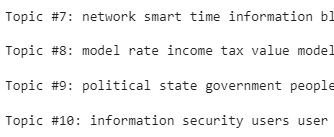

In [23]:
topic_id = 19

In [24]:
new_df = doc_topic_dist.loc[doc_topic_dist['dominant_topic'] == topic_id]

In [25]:
new_df.sort_values(by=[str(topic_id)], ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,dominant_topic
247,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.999587,19
622,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.011793,0.000012,0.000012,0.987986,19
458,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.000015,0.000015,0.011541,0.000015,0.000015,0.000015,0.000015,0.000015,0.970810,19
69,0.000012,0.000012,0.000012,0.011899,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.028369,0.008437,0.000012,0.000012,0.000012,0.000736,0.950384,19
80,0.037554,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.026605,0.000014,0.935599,19
220,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,...,0.027412,0.000007,0.000007,0.045714,0.000007,0.000681,0.000007,0.000007,0.926089,19
73,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,...,0.067734,0.015579,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.916393,19
387,0.000016,0.000016,0.000016,0.136827,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.862878,19
233,0.000020,0.000020,0.000020,0.131626,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.060020,0.000020,0.789904,19
497,0.000025,0.000025,0.155205,0.000025,0.040253,0.000025,0.000025,0.000025,0.000025,0.000025,...,0.000025,0.000025,0.000025,0.024780,0.000025,0.000025,0.000025,0.000025,0.743022,19


List the first five papers that are most relevant in the topic #0. An example output is shown in the figure below. In the next cell enter any of these number, e.g. 498, 612, 250, 711, 273.

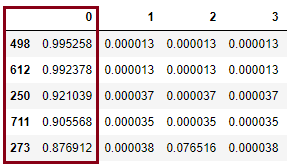

Change `number_of_articles` if you want more papers.

In [26]:
number_of_articles = 10

In [27]:
new_df.sort_values(by=[str(topic_id)], ascending=False)[str(topic_id)].head(number_of_articles)

247    0.999587
622    0.987986
458    0.970810
69     0.950384
80     0.935599
220    0.926089
73     0.916393
387    0.862878
233    0.789904
497    0.743022
Name: 19, dtype: float64

Once you identify papers, use the first number in the row to identify the paper ID. 

In [28]:
info_about_paper(df.iloc[247].paper_id)

## #11. Get recommendation about similar papers. 

Enter the paper ID in the first field, and different number of papers in "k=x". 5 is the default number of papers.

In [29]:
recommendation('383e02b0d5ee6a8b399add42afec5208eea76ed5', k=5, plot_dna=True)

Consumer responses to savings message framing


## #12. Different approach for getting recommendations

This is a list of papers in the text corpus presented with a title. When you click on the title, you will get a recommendation about similar papers.

In [30]:
related_papers()

## #13. Map your text into the LDA space and get recommendation about similar papers

**You can try the following text:**
Although the relationship between IT use and salesperson performance remains primarily unsubstantiated, many organizations spend considerable human and financial resources in equipping their sales forces with IT. The cost of automating a sales force can be upwards of $3,500 per salesperson (Girard 1998), and more than 60% of all SFA projects have been unsuccessful (Rivers and Dart 1999). Meanwhile, companies continue to invest in SFA technology in the hopes that improving the speed and quality of information flow among the salespersons will ultimately deliver dividends (Speier and Venkatesh 2002). Marketing and information systems (IS) researchers alike have called for more research in the area of technology use and its impact on salesperson performance (Leigh and Marshall 2001, Marshall et al. 1999) and organizational performance generally (Venkatesh 2006).



**Please note that the link to the similar file will be available only if the link exists in the database.**



In [31]:
relevant_articles_for_text()

Although the relationship between IT use and salesperson performance remains primarily unsubstantiated, many organizations spend considerable human and financial resources in equipping their sales forces with IT. The cost of automating a sales force can be upwards of $3,500 per salesperson (Girard 1998), and more than 60% of all SFA projects have been unsuccessful (Rivers and Dart 1999). Meanwhile, companies continue to invest in SFA technology in the hopes that improving the speed and quality of information flow among the salespersons will ultimately deliver dividends (Speier and Venkatesh 2002). Marketing and information systems (IS) researchers alike have called for more research in the area of technology use and its impact on salesperson performance (Leigh and Marshall 2001, Marshall et al. 1999) and organizational performance generally (Venkatesh 2006).
